#**LSTM Practice**
## Stock Analysis(Samsung electronics)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pandas_datareader import data as pdr

In [ ]:
!pip install finance-datareader
import FinanceDataReader as fdr

In [ ]:
start_date = '2011-09-01'

samsung = fdr.DataReader('005930',start_date)
samsung.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2011-09-01,15180,15760,14880,15420,717411,0.036290
2011-09-02,15299,15620,15260,15380,258682,-0.002594
2011-09-05,15100,15120,14600,14620,277488,-0.049415
2011-09-06,14520,14720,14200,14540,264505,-0.005472
2011-09-07,14660,15560,14660,15460,351504,0.063274


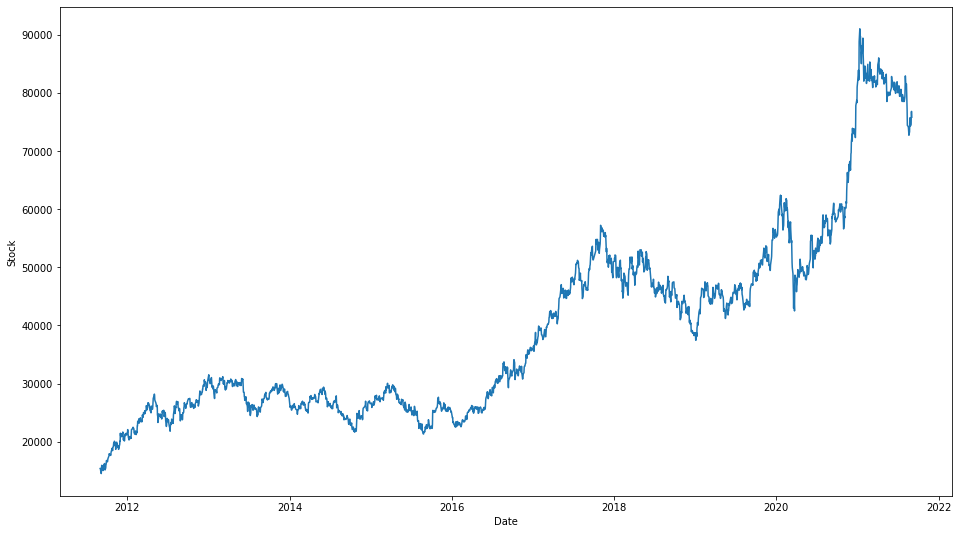

In [ ]:
plt.figure(figsize=(16,9))
sns.lineplot(y = samsung['Close'], x = samsung.index)
plt.xlabel('Date')
plt.ylabel('Stock')

plt.show()

# **Normalization**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

scale_columns = ['Open','High','Low','Close','Volume']

scaled = scalar.fit_transform(samsung[scale_columns])

scaled

array([[0.16810631, 0.16280992, 0.16625698, 0.01150929, 0.00794421],
       [0.16942414, 0.16136364, 0.17050279, 0.01098614, 0.0028645 ],
       [0.16722038, 0.15619835, 0.16312849, 0.0010463 , 0.00307275],
       ...,
       [0.82945736, 0.79235537, 0.8301676 , 0.8129741 , 0.27274292],
       [0.84939092, 0.7964876 , 0.84804469, 0.81428198, 0.17844599],
       [0.85049834, 0.79338843, 0.84581006, 0.80381899, 0.16831925]])

In [ ]:
df = pd.DataFrame(data = scaled, columns=scale_columns)

df.head()

,Open,High,Low,Close,Volume
0,0.168106,0.162810,0.166257,0.011509,0.007944
1,0.169424,0.161364,0.170503,0.010986,0.002864
2,0.167220,0.156198,0.163128,0.001046,0.003073
3,0.160797,0.152066,0.158659,0.000000,0.002929
4,0.162348,0.160744,0.163799,0.012032,0.003892


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('Close',axis=1), df['Close'],
                                                    test_size=0.2, random_state=0,shuffle=False)

x_train.shape, y_train.shape


((1972, 4), (1972,))

In [ ]:
x_val = tf.reverse(x_train, [-1])
y_val = tf.reverse(y_train, [-1])
y_val = tf.expand_dims(y_val, axis=-1)

x_train = tf.reverse(x_train, [-1])
y_train = tf.reverse(y_train, [-1])
x_val.shape, y_val.shape

(TensorShape([1972, 4]), TensorShape([1972, 1]))

# **Tensorflow 를 이용한 Sequence dataset 구성하기**

In [ ]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle):
  series = tf.expand_dims(series, axis=1)

  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size +1, shift =1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size +1))
  if shuffle :
    ds = ds.shuffle(1000)
  ds = ds.map(lambda w: (w[ :-1], w[-1]))
  return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE = 20
BATCH_SIZE= 32

train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)


In [ ]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


# **Modeling**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
x_train = tf.expand_dims(x_train, axis=-1)
y_train = tf.expand_dims(y_train, axis=1)
x_train.shape, y_train.shape

(TensorShape([1972, 1, 1, 1, 4]), TensorShape([1972, 1, 1]))

In [ ]:
model = Sequential([Conv1D(filters=32, kernel_size=5,padding='causal',
                           activation='relu',input_shape=[WINDOW_SIZE, 1]),
                    LSTM(16, activation='tanh'),Dense(16, activation ='relu'),Dense(1)])

model.compile(loss=Huber(),optimizer=Adam(0.0005), metrics='mse')

history = model.fit(train_data, batch_size=BATCH_SIZE, epochs=50, verbose='auto')

Epoch 1/50
61/61 [==============================] - 3s 13ms/step - loss: 0.0044 - mse: 0.0088
Epoch 2/50
61/61 [==============================] - 1s 14ms/step - loss: 4.9788e-04 - mse: 9.9577e-04
Epoch 3/50
61/61 [==============================] - 1s 13ms/step - loss: 1.1860e-04 - mse: 2.3719e-04
Epoch 4/50
61/61 [==============================] - 1s 13ms/step - loss: 1.0461e-04 - mse: 2.0923e-04
Epoch 5/50
61/61 [==============================] - 1s 14ms/step - loss: 1.0247e-04 - mse: 2.0494e-04
Epoch 6/50
61/61 [==============================] - 1s 13ms/step - loss: 1.0212e-04 - mse: 2.0423e-04
Epoch 7/50
61/61 [==============================] - 1s 13ms/step - loss: 1.0141e-04 - mse: 2.0282e-04
Epoch 8/50
61/61 [==============================] - 1s 13ms/step - loss: 9.9969e-05 - mse: 1.9994e-04
Epoch 9/50
61/61 [==============================] - 1s 13ms/step - loss: 9.7439e-05 - mse: 1.9488e-04
Epoch 10/50
61/61 [==============================] - 1s 13ms/step - loss: 9.5518e-05 - mse

In [ ]:
history = model.fit(train_data, batch_size=BATCH_SIZE, epochs=100, verbose=0)

In [ ]:
pred = model.predict(test_data)
pred.shape

(474, 1)

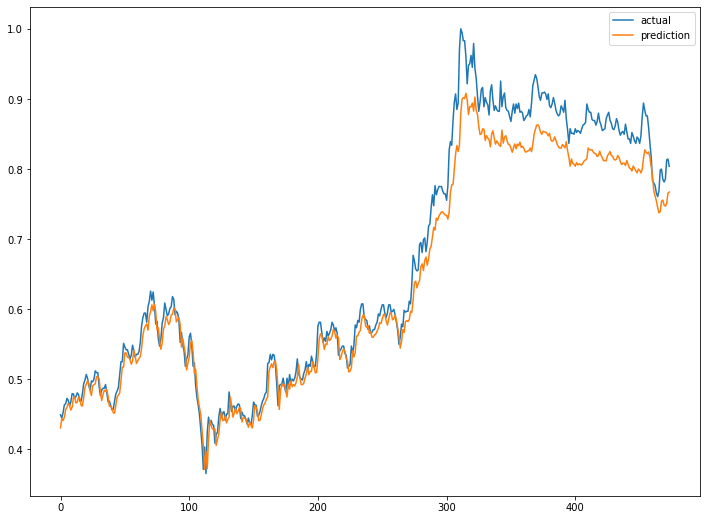

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

전날과 다음날과의 차이를 가지고 다시 만들어봐야겠다.